In [72]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave
import matplotlib.pyplot as plt

In [73]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [74]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [75]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [76]:
m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 50

In [77]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

In [78]:
inputs = concat([X, label])

In [79]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [80]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [81]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [82]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [83]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [84]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [85]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [86]:
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
validation_data = ([X_test, y_test], X_test),
callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 201us/step - loss: 198.9286 - KL_loss: 9.5189 - recon_loss: 189.4097 - val_loss: 155.6387 - val_KL_loss: 4.4984 - val_recon_loss: 151.1403
Epoch 2/50
60000/60000 [==============================] - 12s 196us/step - loss: 149.0539 - KL_loss: 4.3554 - recon_loss: 144.6985 - val_loss: 144.3611 - val_KL_loss: 4.2249 - val_recon_loss: 140.1362
Epoch 3/50
60000/60000 [==============================] - 13s 209us/step - loss: 142.7837 - KL_loss: 4.2743 - recon_loss: 138.5094 - val_loss: 141.0848 - val_KL_loss: 4.1982 - val_recon_loss: 136.8866
Epoch 4/50
60000/60000 [==============================] - 12s 199us/step - loss: 140.2461 - KL_loss: 4.2722 - recon_loss: 135.9739 - val_loss: 139.3178 - val_KL_loss: 4.2946 - val_recon_loss: 135.0233
Epoch 5/50
60000/60000 [==============================] - 12s 207us/step - loss: 138.7531 - KL_loss: 4.2813 - recon_loss: 134.4719 - val_loss: 138

60000/60000 [==============================] - 12s 199us/step - loss: 129.7484 - KL_loss: 4.7161 - recon_loss: 125.0323 - val_loss: 130.9643 - val_KL_loss: 4.6326 - val_recon_loss: 126.3316
Epoch 42/50
60000/60000 [==============================] - 13s 213us/step - loss: 129.6723 - KL_loss: 4.7107 - recon_loss: 124.9617 - val_loss: 130.9321 - val_KL_loss: 4.7073 - val_recon_loss: 126.2248
Epoch 43/50
60000/60000 [==============================] - 15s 253us/step - loss: 129.6206 - KL_loss: 4.7251 - recon_loss: 124.8955 - val_loss: 130.8419 - val_KL_loss: 4.6232 - val_recon_loss: 126.2187
Epoch 44/50
60000/60000 [==============================] - 13s 219us/step - loss: 129.5469 - KL_loss: 4.7224 - recon_loss: 124.8245 - val_loss: 130.9677 - val_KL_loss: 4.6933 - val_recon_loss: 126.2744
Epoch 45/50
60000/60000 [==============================] - 12s 203us/step - loss: 129.5227 - KL_loss: 4.7357 - recon_loss: 124.7870 - val_loss: 130.8066 - val_KL_loss: 4.5648 - val_recon_loss: 126.2419
Ep

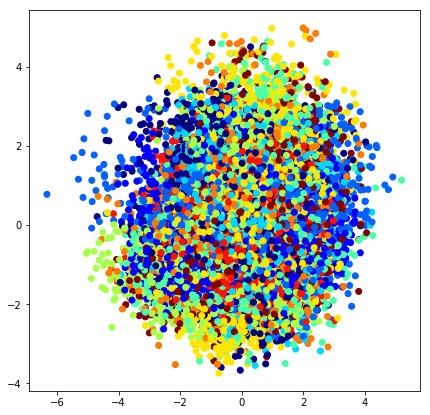

In [87]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

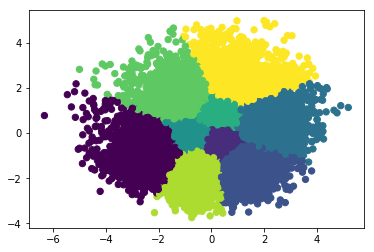

In [88]:
#Now let's play with some clustering algorithms
from sklearn.cluster import KMeans
kmeans = KMeans(9, random_state=0)
labels = kmeans.fit(encodings).predict(encodings)
plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=40, cmap='viridis');

In [89]:
from sklearn.mixture import GaussianMixture as GMM

In [91]:
gmm = GMM(n_components=9).fit(encodings)

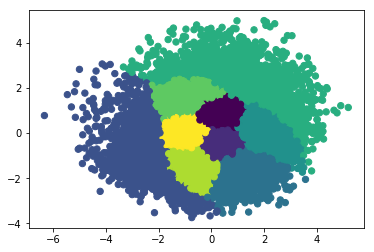

In [104]:
labels = gmm.predict(encodings)
plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=40, cmap='viridis');

#Pick elements corresponding to n-th label
n= 5

subset = []
for i in range(0,labels.size):
    if labels[i]==n:
        subset.append(encodings[i])
    else:
        pass
subset = np.array(subset) 

In [105]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(6)
print(sample_3)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


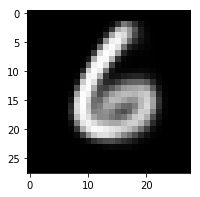

In [106]:
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray)
plt.show()

In [116]:
decoder.predict(construct_numvec(4,subset[7]))

array([[8.08155192e-12, 1.04788522e-11, 8.43983477e-12, 1.51737060e-11,
        2.55790389e-11, 2.05742003e-11, 1.10974467e-11, 1.61753857e-11,
        5.73888246e-12, 8.29752152e-12, 7.95393786e-12, 1.23064302e-11,
        1.84931764e-07, 1.57879949e-08, 2.87972370e-07, 1.52263397e-07,
        1.13955763e-11, 1.18624138e-11, 1.63863281e-11, 5.88665271e-12,
        1.21181780e-11, 1.14915490e-11, 2.04315419e-11, 1.01086960e-11,
        1.93300341e-11, 1.22921664e-11, 9.78735582e-12, 1.46565381e-11,
        1.15171345e-11, 1.68737871e-11, 1.47974341e-11, 8.76371285e-12,
        1.85164120e-10, 1.30900854e-11, 6.41229569e-11, 3.73203079e-07,
        2.79678056e-06, 3.31040326e-07, 6.92632298e-08, 3.14205231e-08,
        1.51865844e-08, 4.47122193e-06, 2.75813480e-04, 8.14374687e-07,
        6.26533547e-10, 7.98076222e-15, 7.73545269e-16, 2.79077840e-13,
        7.06590397e-10, 4.01946254e-10, 9.44433181e-15, 2.84785910e-12,
        1.38623800e-11, 1.71768190e-11, 9.88402589e-12, 1.875018